📂 Loading Data...
🔗 Merging Datasets...
📅 Processing Dates...
🔢 Encoding categorical features...
🤖 Training Models...

⚡ Training RandomForest...
RandomForest - RMSE: 5940.89, MAE: 2948.37

⚡ Training XGBoost...
XGBoost - RMSE: 5672.64, MAE: 3193.83

⚡ Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2530
[LightGBM] [Info] Number of data points in the train set: 337256, number of used features: 17
[LightGBM] [Info] Start training from score 15979.221909
LightGBM - RMSE: 8001.39, MAE: 4864.93

✅ Best Model Saved: XGBoost

🔮 Running Forecast on Test Data...

✅ Future Forecast Saved: future_forecast.csv


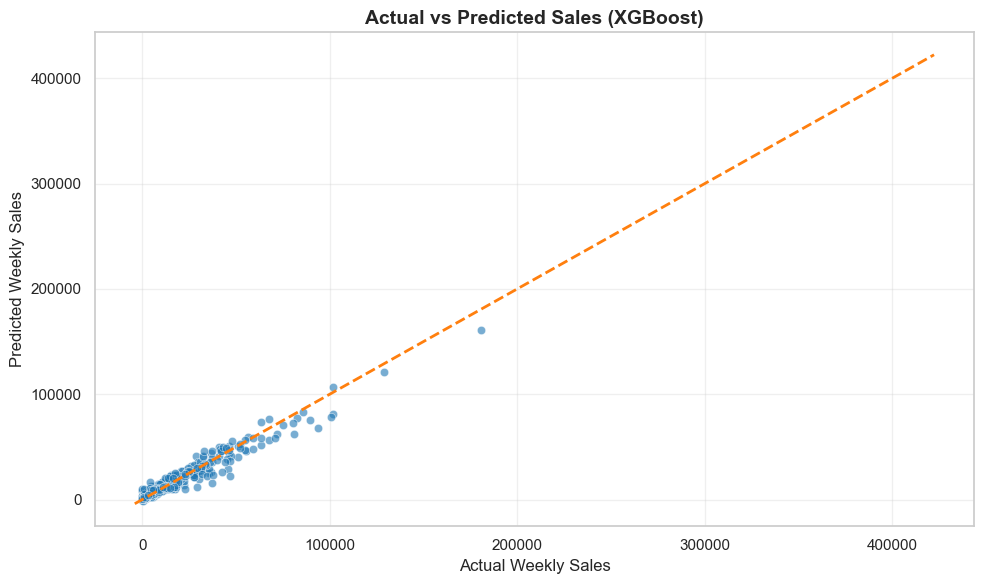

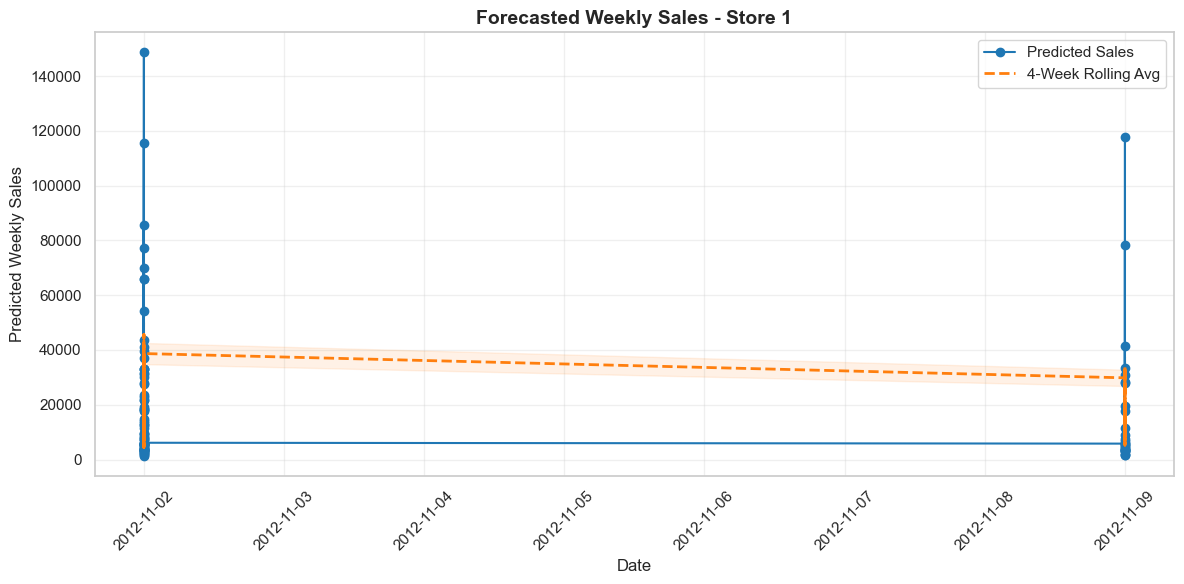

C:\Users\LAPTOPINN\AppData\Local\Temp\ipykernel_10244\314881279.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Predicted_Weekly_Sales", y="Store", data=store_forecast, palette="mako")


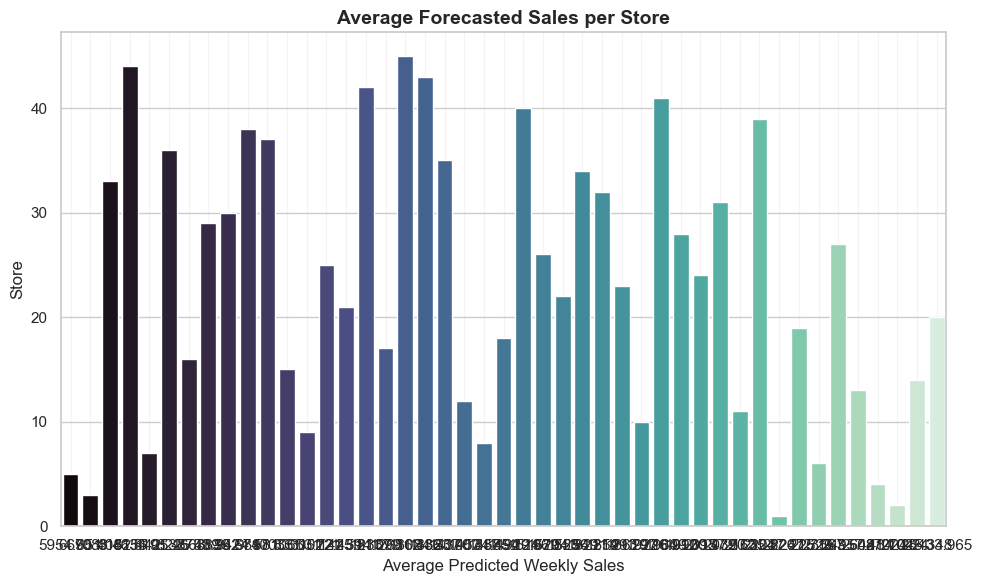

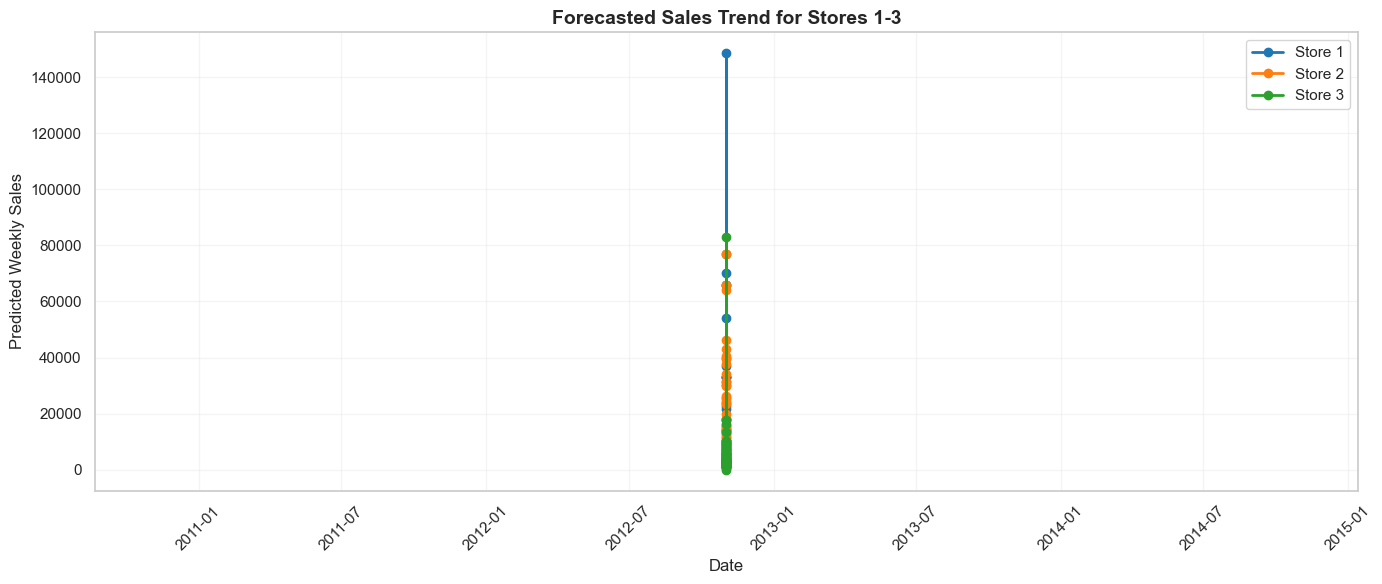

In [6]:
# =========================
# Walmart Sales Forecasting (Optimized + Professional Visualization) ✅
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

sns.set(style="whitegrid")  # professional style

# ========== Load Data ==========
print("📂 Loading Data...")
train = pd.read_csv("C:\\Users\\LAPTOPINN\\Downloads\\walmart-sales-forecast\\data\\train.csv")
test = pd.read_csv("C:\\Users\\LAPTOPINN\\Downloads\\walmart-sales-forecast\\data\\test.csv")
features = pd.read_csv("C:\\Users\\LAPTOPINN\\Downloads\\walmart-sales-forecast\\data\\features.csv")
stores = pd.read_csv("C:\\Users\\LAPTOPINN\\Downloads\\walmart-sales-forecast\\data\\stores.csv")

# ========== Merge ==========
print("🔗 Merging Datasets...")
train = train.merge(features, on=["Store","Date","IsHoliday"], how="left")
train = train.merge(stores, on="Store", how="left")

test = test.merge(features, on=["Store","Date","IsHoliday"], how="left")
test = test.merge(stores, on="Store", how="left")

# ========== Handle Date ==========
print("📅 Processing Dates...")
for df in [train, test]:
    df["Date"] = pd.to_datetime(df["Date"])
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Week"] = df["Date"].dt.isocalendar().week.astype(int)

# ========== Encode Categorical ==========
print("🔢 Encoding categorical features...")
cat_cols = [col for col in train.select_dtypes(include="object").columns if col != "Date"]

for col in cat_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

# ========== Feature/Target ==========
X = train.drop(columns=["Weekly_Sales", "Date"])
y = train["Weekly_Sales"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ========== Models ==========
print("🤖 Training Models...")
models = {
    "RandomForest": RandomForestRegressor(n_estimators=60, max_depth=12, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=60, learning_rate=0.1, max_depth=8, random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMRegressor(n_estimators=60, learning_rate=0.1, max_depth=8, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n⚡ Training {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae = mean_absolute_error(y_val, preds)
    
    results[name] = {"RMSE": rmse, "MAE": mae}
    print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# ========== Save Best Model ==========
best_model_name = min(results, key=lambda k: results[k]["RMSE"])
best_model = models[best_model_name]

joblib.dump(best_model, "best_model.pkl")
print(f"\n✅ Best Model Saved: {best_model_name}")

# ========== Future Forecast ==========
print("\n🔮 Running Forecast on Test Data...")
future_preds = best_model.predict(test.drop(columns=["Date", "Weekly_Sales"], errors="ignore"))
test["Predicted_Weekly_Sales"] = future_preds

# Save Forecast
test[["Store","Dept","Date","Predicted_Weekly_Sales"]].to_csv("future_forecast.csv", index=False)
print("\n✅ Future Forecast Saved: future_forecast.csv")

# =========================
# Professional Visualizations
# =========================

import matplotlib.dates as mdates

# 1️⃣ Actual vs Predicted (Validation Set)
val_preds = best_model.predict(X_val)
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_val[:500], y=val_preds[:500], alpha=0.6, color="#1f77b4")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color="#ff7f0e", linestyle="--", linewidth=2)
plt.xlabel("Actual Weekly Sales", fontsize=12)
plt.ylabel("Predicted Weekly Sales", fontsize=12)
plt.title(f"Actual vs Predicted Sales ({best_model_name})", fontsize=14, fontweight="bold")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2️⃣ Forecasted Sales Over Time - Store 1 with Rolling Average
store1 = test[test["Store"] == 1].sort_values("Date").head(100)
store1["Rolling_4W"] = store1["Predicted_Weekly_Sales"].rolling(4).mean()

plt.figure(figsize=(12,6))
plt.plot(store1["Date"], store1["Predicted_Weekly_Sales"], marker="o", linestyle="-", color="#1f77b4", label="Predicted Sales")
plt.plot(store1["Date"], store1["Rolling_4W"], linestyle="--", color="#ff7f0e", label="4-Week Rolling Avg", linewidth=2)
plt.fill_between(store1["Date"], store1["Rolling_4W"]*0.9, store1["Rolling_4W"]*1.1, color="#ff7f0e", alpha=0.1)
plt.title("Forecasted Weekly Sales - Store 1", fontsize=14, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Predicted Weekly Sales")
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3️⃣ Store-wise Average Forecast - Horizontal Bar
store_forecast = test.groupby("Store")["Predicted_Weekly_Sales"].mean().sort_values().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(x="Predicted_Weekly_Sales", y="Store", data=store_forecast, palette="mako")
plt.xlabel("Average Predicted Weekly Sales", fontsize=12)
plt.ylabel("Store", fontsize=12)
plt.title("Average Forecasted Sales per Store", fontsize=14, fontweight="bold")
plt.grid(axis="x", alpha=0.2)
plt.tight_layout()
plt.show()

# 4️⃣ Multi-Store Forecast Trend (Stores 1-3)
plt.figure(figsize=(14,6))
colors = ["#1f77b4","#ff7f0e","#2ca02c"]
for i, store_id in enumerate([1,2,3]):
    store_data = test[test["Store"] == store_id].sort_values("Date").head(50)
    plt.plot(store_data["Date"], store_data["Predicted_Weekly_Sales"], marker="o", linestyle="-",
             color=colors[i], label=f"Store {store_id}", linewidth=2)
plt.title("Forecasted Sales Trend for Stores 1-3", fontsize=14, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Predicted Weekly Sales")
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()
